In [80]:
import os
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

def correlate(e1, e2=None):
    if e2 is None:
        e2 = e1
    return e1 @ e2.T

def correlate_minus_diag(e1):
    correlation = e1 @ e1.T
    return correlation - (1 - correlation.mean()) * np.eye(correlation.shape[0])

with open('.env') as f:
    openai.api_key = f.read().strip().split('=')[1]

anthems_dir = Path('data/anthems')
file_paths = {}
lyrics = {}
embeddings = {}

for g in anthems_dir.glob('*.txt'):
    stem = g.stem
    file_paths[stem] = g
    
    with open(g) as f:
        lyrics[stem] = np.asarray([line.strip() for line in f.readlines() if line.strip() != ""])

    emb_path = g.with_suffix('.emb')
    if os.path.isfile(emb_path):
        print(f"Loading {stem} from file")
        embeddings[stem] = np.loadtxt(emb_path)
    else:
        print(f"Fetching {stem} from OpenAI")
        response = openai.Embedding.create(input=list(lyrics[stem]), model="text-embedding-ada-002")
        embeddings[stem] = np.asarray([e.embedding for e in response['data']])
        np.savetxt(emb_path, embeddings[stem])

Loading USA from file
Loading RUS from file
Fetching CAN from OpenAI
Fetching GBR from OpenAI
Fetching PRK from OpenAI
Fetching KOR from OpenAI


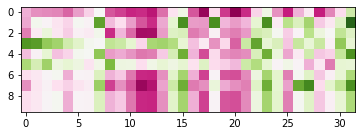

In [87]:
plt.imshow(correlate(embeddings['CAN'], embeddings['USA']), cmap='PiYG')

In [91]:
country1 = 'GBR'
country2 = 'CAN'
c = correlate(embeddings[country1], embeddings[country2])
idx1, idx2 = np.unravel_index(c.argmax(), c.shape)

print(c.max())

lyrics[country1][idx1], lyrics[country2][idx2]

0.883780826497528


('God save us all!', 'God keep our land glorious and free!')

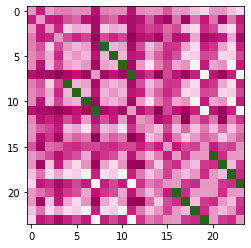

In [94]:
plt.imshow(correlate_minus_diag(embeddings['PRK']), cmap='PiYG')

In [95]:
for key in embeddings.keys():
    print(key, embeddings[key].shape)

USA (32, 1536)
RUS (20, 1536)
CAN (10, 1536)
GBR (21, 1536)
PRK (24, 1536)
KOR (16, 1536)


In [99]:
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)

kmeans.fit(embeddings['PRK'])
labels = kmeans.labels_

In [100]:
df = pd.DataFrame({'lyric': lyrics['PRK'], 'cluster': labels})
df

,lyric,cluster
0,아침은 빛나라 이 강산,2
1,은금에 자원도 가득한,1
2,삼천리 아름다운 내 조국,2
3,반만년 오랜 력사에,2
4,찬란한 문화로 자라난,1
5,슬기론 인민의 이 영광,1
6,몸과 맘 다 바쳐 이 조선,2
7,길이 받드세,0
8,찬란한 문화로 자라난,1
9,슬기론 인민의 이 영광,1


Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

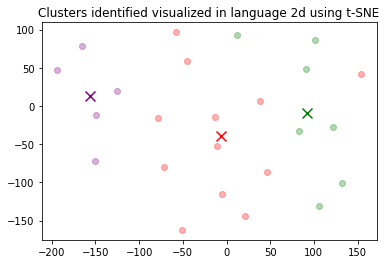

In [103]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(embeddings['PRK'])

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue", "black"][:n_clusters]):
    xs = np.array(x)[df.cluster == category]
    ys = np.array(y)[df.cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

In [104]:
rev_per_cluster = 3

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    lyrics = "\n".join(
        df[df.cluster == i]
        .lyric
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What do the following lyrics have in common?\n\nLyrics:\n"""\n{lyrics}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = df[df.cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.lyric.values[j])

    print("-" * 100)

Cluster 0 Theme:  Perseverance and determination
길이 받드세
길이 빛내세
온 세계 앞서 나가리
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  Pride in one's country and culture
은금에 자원도 가득한
찬란한 문화로 자라난
인민의 뜻으로 선 나라
----------------------------------------------------------------------------------------------------
Cluster 2 Theme:  The beauty of Korea
솟는 힘 노도도 내밀어
한없이 부강하는 이 조선
아침은 빛나라 이 강산
----------------------------------------------------------------------------------------------------
